# Modeling 

## Load Processed Dataset 
Load cleaned and feature-engineered data output from preprocessing pipeline.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns 
import xgboost as xgb
import datetime
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance


In [2]:
# Load training data
train_df = pd.read_csv("../data/processed/training_data.csv")

# Load final evaluation data
test_df = pd.read_csv("../data/processed/test_data.csv")

## Define Features (X) and Target (y)
Seperate the target (Log Views) and the input features for modeling 

In [3]:
# Seperating X and y for the training data
y = train_df['log_views']
X = train_df.drop(['log_views'], axis = 1 )

In [4]:
#seperating X and Y for the final evaluation data
y_eval = test_df['log_views']
X_eval = test_df.drop(['log_views'], axis = 1 )

## Train/Test Split 
Holds 20% of the data to be used to evaluate baseline model preformance for model selection.

In [5]:
# Creates train/test splits for the target variable and features.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

## Baseline Models
Fit and compare several simple models to establish benchmark predictive performance.

In [6]:
# Initialising base models
linear_regressor = LinearRegression()
lasso = Lasso(alpha= 1.0)
ridge = Ridge(alpha= 1.0)
random_forest_regressor = RandomForestRegressor(n_estimators= 100, max_depth= None, random_state= 42, n_jobs= -1 )
xgb_regressor = xgb.XGBRegressor(n_estimators = 300, max_depth = 6, learning_rate = 0.1, subsample = 0.8, 
                            colsample_bytree = 0.8, random_state = 42, n_jobs = -1 )


In [7]:
# Fitting models on training data
linear_regressor.fit(X_train, y_train)
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
random_forest_regressor.fit(X_train, y_train)
xgb_regressor.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## Results & Model Selection 
Summarize baseline metrics and choose models for hyperparameter tuning.

In [8]:
# Predicts target variables based on fitted models 
linear_regression_pred = linear_regressor.predict(X_test)
lasso_pred = lasso.predict(X_test)
ridge_pred = ridge.predict(X_test)
random_forest_pred = random_forest_regressor.predict(X_test)
xgb_pred = xgb_regressor.predict(X_test)

In [9]:
# Calculates the Mean Squared Error of the models predictions and records the results
results = {}
results["linear_regression"] = mean_squared_error(y_test, linear_regression_pred)
results["lasso"] =  mean_squared_error(y_test, lasso_pred)
results["ridge"] = mean_squared_error(y_test, ridge_pred)
results["random_forest"] = mean_squared_error(y_test, random_forest_pred)
results["xgb"] = mean_squared_error(y_test, xgb_pred)

In [10]:
# Displays the results in ascending order 
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['MSE'])
results_df = results_df.sort_values(by='MSE')
results_df

,MSE
random_forest,0.115948
xgb,0.330288
ridge,0.887046
linear_regression,0.887049
lasso,1.017676


Since the random forest performed significantly better than the other models assessed, it will be the model selected.

## Hyperparameter Tuning
Using grid search cross validation to select the best parameter value. 

In [11]:
# Creating parameter grid for grid dearch cross validation 
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": [None, 'sqrt', 'log2'],  
    "bootstrap": [True, False]
}

In [12]:
# Grid search fit
grid_search = GridSearchCV(estimator= RandomForestRegressor(), param_grid= param_grid, cv = 2, n_jobs = -1)
grid_search.fit(X, y)

,estimator,RandomForestRegressor()
,param_grid,"{'bootstrap': [True, False], 'max_depth': [None, 5, ...], 'max_features': [None, 'sqrt', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,2
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,300


In [13]:
# Obtaining the best parameter values evaluated from grid search
best_params = grid_search.best_params_


## Evaluating Tuned Model
Evaluating the model effectiveness using the test data set aside from the preprocessing pipeline.

In [14]:
# Using tuned parameters, the model is fit on the training dataset. 
tuned_model= RandomForestRegressor(**best_params)
tuned_model.fit(X, y)

,n_estimators,300
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [15]:
# Predicting target variable using evaluation data
tuned_pred = tuned_model.predict(X_eval)

In [16]:
#Evaluating MSE
tuned_mse = mean_squared_error(y_eval, tuned_pred)
print(tuned_mse)

0.08055899515668838


In [17]:
# Fitting baseline model on whole training data and predicting on evalution data to compare to tuned model
random_forest_regressor.fit(X, y)
baseline_pred = random_forest_regressor.predict(X_eval)
basline_mse = mean_squared_error(y_eval, baseline_pred)
print(f"Tuned MSE: {tuned_mse}, Baseline MSE: {basline_mse}")

Tuned MSE: 0.08055899515668838, Baseline MSE: 0.09080473236572066


In [24]:
print(type(y_eval))

<class 'pandas.core.series.Series'>


In [18]:
mse_dif = basline_mse - tuned_mse
print(f"Difference in MSE: {mse_dif}")

Difference in MSE: 0.010245737209032282


## Model Interpretation 
Plotting the important features of the model to allow fo interpretation

[0.00615419 0.0030753  0.2103624  0.1683866  0.16059424 0.0183496
 0.0129841  0.01183993 0.01925574 0.01987981 0.01752108 0.00800497
 0.00794486 0.00803276 0.00748232 0.00710673 0.00421141 0.0061199
 0.00677661 0.00563519 0.00618857 0.00584421 0.00839292 0.01008373
 0.01249967 0.01341411 0.01384841 0.01305418 0.01167216 0.01174883
 0.01210385 0.00933325 0.00938817 0.0081443  0.00710795 0.00587501
 0.01215967 0.00838279 0.00523    0.00672    0.03497084 0.02906219
 0.00246952 0.00830353 0.00368461 0.00739711 0.0002841  0.0104338
 0.00248479]


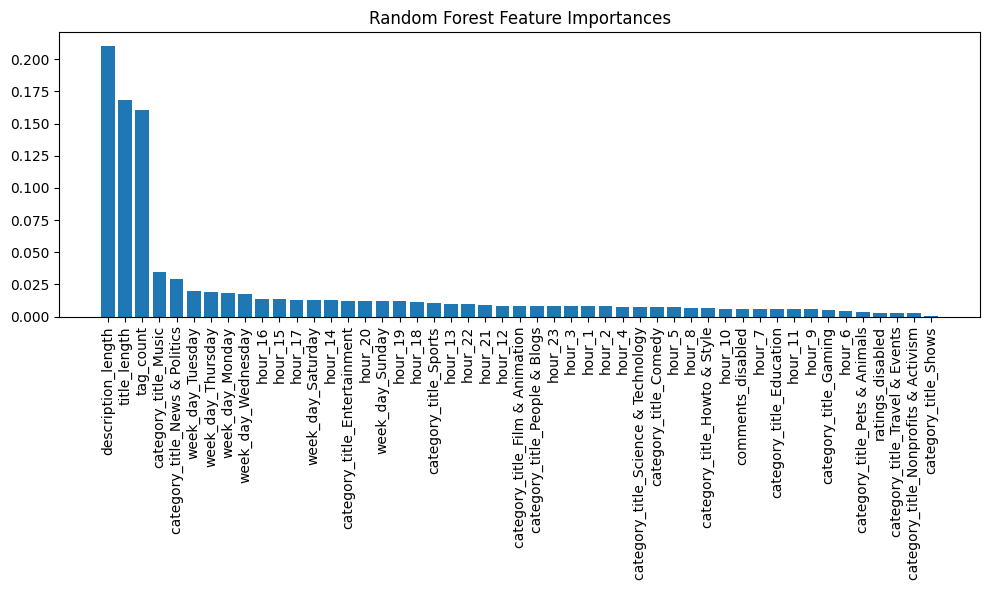

In [19]:
# Plotting the feature importantance according to impurity
importances = tuned_model.feature_importances_    
feature_names = X.columns              

# Sort features by importance (descending)
sorted_idx = importances.argsort()[::-1]      

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")

plt.bar(range(len(importances)),              
        importances[sorted_idx],
        align="center")

plt.xticks(range(len(importances)),           
           feature_names[sorted_idx],
           rotation=90)

plt.tight_layout()                            
plt.show()

Based on this plot it would seem that the continuous variables are of the greatest importance in model by a significant margin. This however may not be an accurate representation of overall feature importance due to the measure (impurity) used which has a bias toward high cardinality feature. Thus further investigation must be done as the results may be biased.    

In [20]:
# Permutation feature importance assessment   
result = permutation_importance(
    estimator=tuned_model,
    X=X_eval,
    y=y_eval,
    n_repeats=10,             
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs= -1
)

# Put into a DataFrame
perm_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(perm_df)



                                 feature  importance_mean  importance_std
2                     description_length         0.441300        0.003049
4                              tag_count         0.440985        0.005089
3                           title_length         0.351271        0.004268
40                  category_title_Music         0.316875        0.008283
41        category_title_News & Politics         0.105241        0.002827
36          category_title_Entertainment         0.090329        0.002004
37       category_title_Film & Animation         0.069967        0.001176
10                    week_day_Wednesday         0.055135        0.001258
9                       week_day_Tuesday         0.055013        0.001054
39          category_title_Howto & Style         0.054342        0.001284
7                        week_day_Sunday         0.053550        0.001190
8                      week_day_Thursday         0.048173        0.001781
5                        week_day_Mond

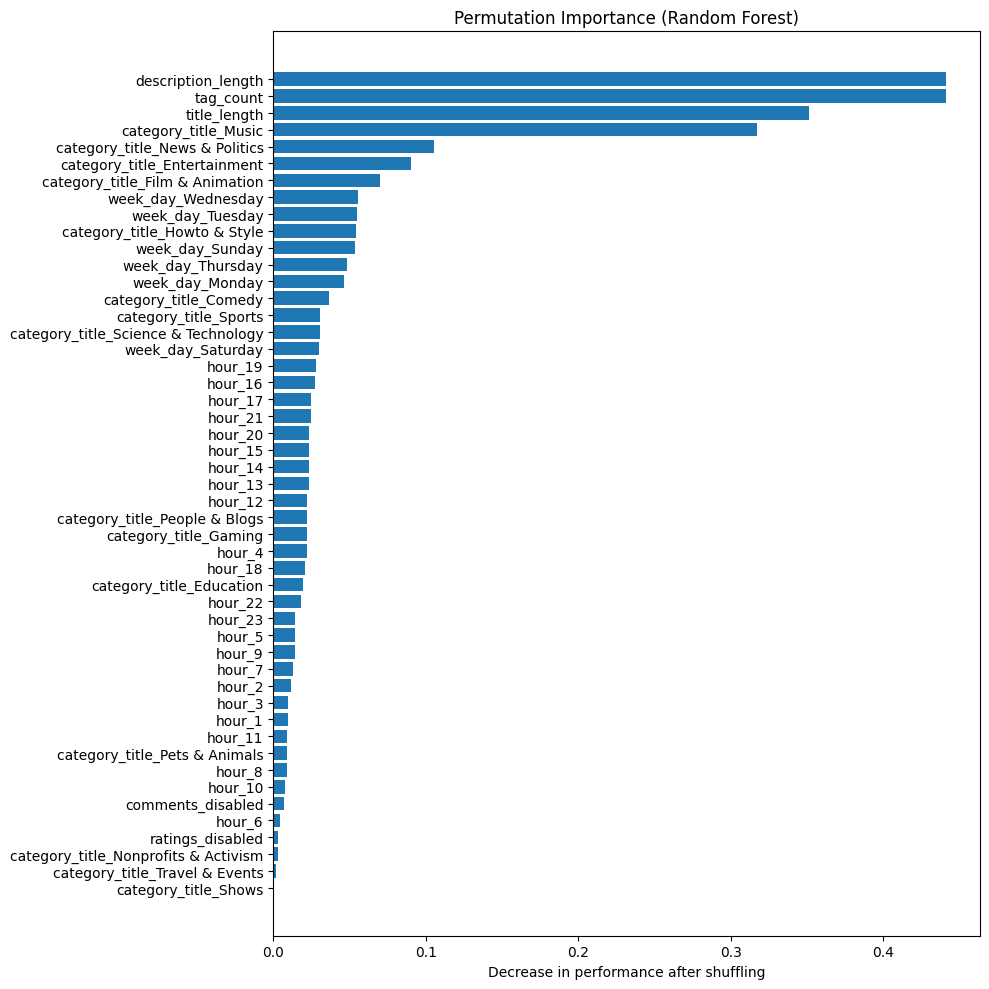

In [21]:
# Plotting the permutation feature importances
plt.figure(figsize= (10,10))
plt.barh(perm_df['feature'], perm_df['importance_mean'])
plt.xlabel('Decrease in performance after shuffling')
plt.title('Permutation Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Using the permutation feature importance evaluation method, which is more robust, we similar result to the impurity method. Thus, there seems to be evidence that the continuous variables are the most important for the model's preformance.  

## Saving model
Saving model for reproducability and experimentation 

In [22]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(tuned_model,f"../models/xgb_model_{timestamp}.json")

['../models/xgb_model_20250820_202629.json']